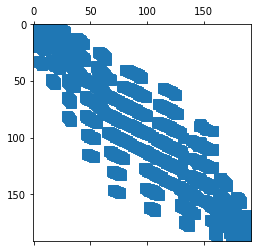

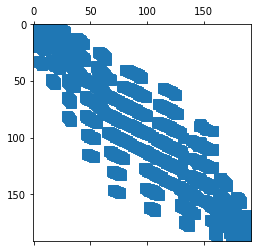

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [1]:
import scipy.sparse
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import pylab as pl
import scipy as sp
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import healpy as hp


nside = 4


L = scipy.sparse.load_npz('../../../HEALPix/10_matrices/stiffness_matrix_{}.npz'.format(nside))
B = scipy.sparse.load_npz('../../../HEALPix/10_matrices/mass_matrix_{}.npz'.format(nside))
reordering_mask = np.load("../../../HEALPix/15_reordering_masks/reordering_mask_{}.npy".format(nside))
L = L[reordering_mask]
B = B[reordering_mask]
plt.spy(L)
plt.show()
plt.spy(B)
plt.show()
B_inv = scipy.sparse.linalg.inv(B)
signal = np.zeros(12*nside**2)
signal[0] = 1

In [2]:
def subplotsphere(fig, signal, coords, tri, j):
    ax = fig.add_subplot(2,2,j+1, projection='3d')
    M = np.max(signal)
    for simplex in tri.simplices:
        triangle = a3.art3d.Poly3DCollection([coords[simplex]])
        triangle.set_color(colors.rgb2hex([np.max(signal[simplex])/M, 0,0]))
        triangle.set_edgecolor('k')
        ax.add_collection3d(triangle)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

# FEM diffusion


In [33]:
B_lumped_inverse = np.diag(1./np.asarray(np.sum(B.todense(), axis=1))[:,0])
B12_lumped_inverse = np.diag(1./np.sqrt(np.asarray(np.sum(B.todense(), axis=1))[:,0]))
BinvL_lumped = B_lumped_inverse@L
BinvL_lumped = scipy.sparse.csc_matrix(BinvL_lumped)
BinvL = B_inv@L
B12LB12_lumped = B12_lumped_inverse@L@B12_lumped_inverse

M1 = scipy.linalg.expm(-0.08*B12LB12_lumped)
M2 = scipy.linalg.expm(-0.08*BinvL_lumped)
M3 = scipy.linalg.expm(-0.08*BinvL)

/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/Mart/anaconda3/envs/deepsphere/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


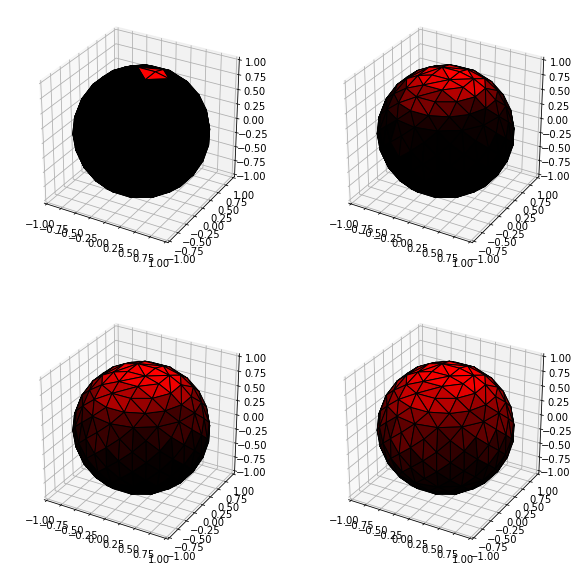

In [34]:
def diffuse_symmetric_lumped(x):
    return M1@x

def diffuse_lumped(x):
    return M2@x

def diffuse(x):
    return M3@x

fig = plt.figure(figsize=(10,10))

signal = np.zeros(12*nside**2)
signal[0] = 1
indexes = range(nside**2 * 12)
x, y, z = hp.pix2vec(nside, indexes)
coords = np.vstack([x, y, z]).transpose()
coords = np.asarray(coords)
tri = ConvexHull(coords)  # just for plotting

for j in range(4):
    subplotsphere(fig, signal, coords, tri, j)
    
    # diffusing 3 times
    for i in range(1):
        signal = abs(diffuse(signal))
        
plt.savefig('FEM_diffusion')

# GRAPH diffusion

2019-05-10 13:56:46,283:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


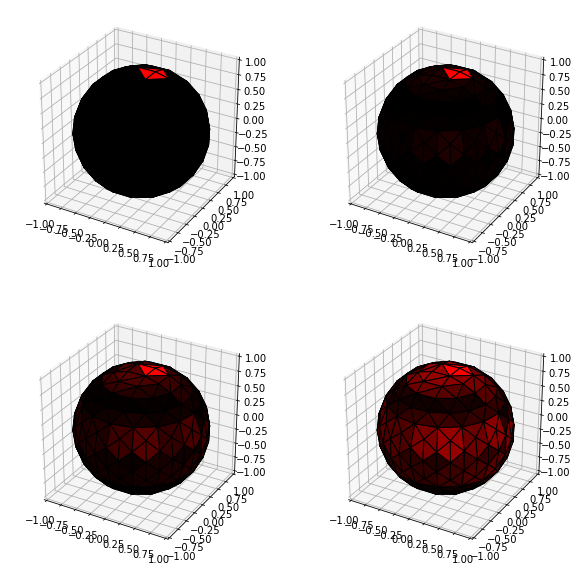

In [18]:
from pygsp import filters
from deepsphere import utils

# re initializing the signal to diffuse
signal = np.zeros(12*nside**2)
signal[0] = 1

fig = plt.figure(figsize=(10,10))
# building the graph and the heat kernel
graph = utils.full_healpix_graph(nside, dtype=np.float64, std=0.3)
heat_kernel = filters.Heat(graph, scale=0.5)

for j in range(4):
    subplotsphere(fig, signal, coords, tri, j)
    
    # diffusing 3 times
    for i in range(3):
        signal = heat_kernel.filter(signal)

plt.savefig('GRAPH_diffusion')